In [30]:
# Data wrangling
import numpy as np
import pandas as pd

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Seaborn settings
sns.set(
    style="ticks",
    context="notebook",
    palette="colorblind"
)

<h1> CRISP-DM - Cross-Industry Standard Process for Data Mining </h1>

This notebook aims to show CRISP-DM process in a churn prediction case with its steps and its inputs and outputs.

# 1 - Business Understanding

## 1.1 - Churn Prediction

Churn prediction is related to detection of which customers tend to cancel a service. Companies spend money to acquire new clients, so clients losses represent investment lost. Retaining clients can be less expensive that acquiring new clients.

**Source**: https://www.avaus.com/blog/predicting-customer-churn/#:~:text=Churn%20prediction%20means%20detecting%20which,more%20than%20retaining%20existing%20ones

## 1.2 - Objectives
In addiction to accuracy, another metrics must be analyzed. It is important to predict churn, but expending money to retain a client that aren't churn must be avoided. Therefore, in addition to accuracy the following metrics with its respectives lower limits will be considered:

# 2 - Data Understanding

## 2.1 - Data Loading

In [4]:
df = pd.read_excel("churn_data.xlsx")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.2 - Initial Exploration

In [5]:
# Showing DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [20]:
# Converting object to category data type and showing memory usage
cat_cols = df.select_dtypes(exclude="number").columns  # Selecting categorical columns
df[cat_cols] = df[cat_cols].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   category
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   int64   
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   tenure            7032 non-null   int64   
 6   PhoneService      7032 non-null   category
 7   MultipleLines     7032 non-null   category
 8   InternetService   7032 non-null   category
 9   OnlineSecurity    7032 non-null   category
 10  OnlineBackup      7032 non-null   category
 11  DeviceProtection  7032 non-null   category
 12  TechSupport       7032 non-null   category
 13  StreamingTV       7032 non-null   category
 14  StreamingMovies   7032 non-null   category
 15  Contract          7032 non-null   category
 16  PaperlessBilling  7032 n

In [21]:
# Showing DataFrame statistics
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [23]:
# Analysis for outliers in numerical cols
num_cols = df.select_dtypes("number").columns  # Selecting numerical columns
df[num_cols].head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


In [34]:
# Feature SeniorCitizen clearly must be treated as categorical
print(df["SeniorCitizen"].unique())

# Before outliers analysis, converting SeniorCitizen to category data type
df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")

# Selecting numerical and categorical columns after converting SeniorCitizen
num_cols = df.select_dtypes("number").columns
cat_cols = df.select_dtypes(exclude="number").columns

[0, 1]
Categories (2, int64): [0, 1]


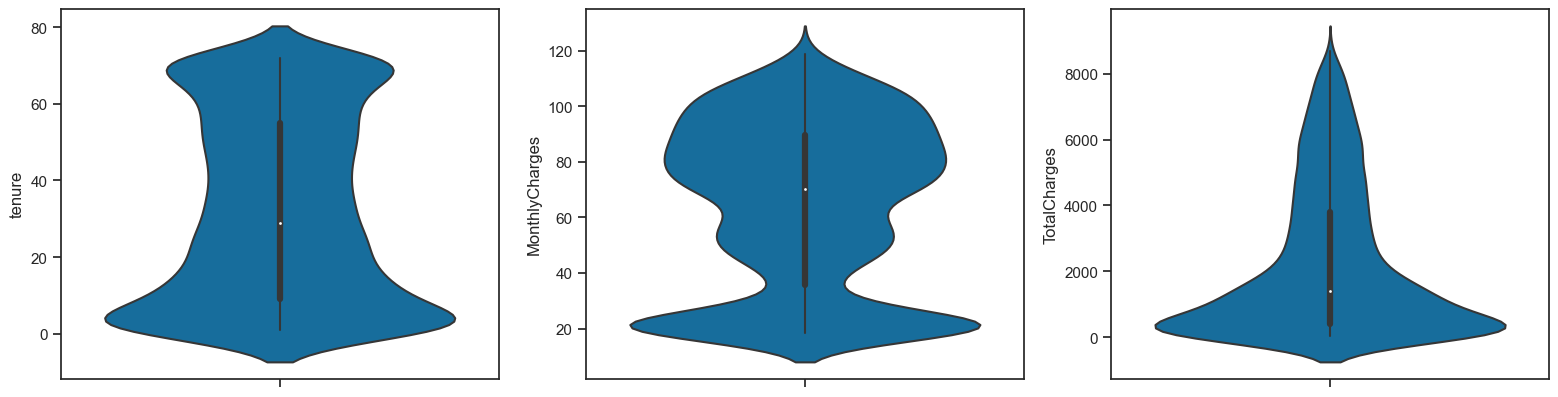

In [49]:
# Plotting violinplot for outliers detection and distribution analysis
fig, axes = plt.subplots(ncols=3, figsize=(6.4*3, 4.8))
for ax, col in zip(axes, num_cols):
    sns.violinplot(data=df, y=col, ax=ax, showfliers=True)

## 2.3 - Initial Exploration Report

- There isn't NaN values;
- There isn't outliers following IQR method;
- Numerical columns must be standardized;
- Categorical cols must be encoded for training models.

# 3 - Data Preparation